In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
from numpy.random import *
from MCF import MCF

###### MCFクラスに、固定ラグ平滑化(Filteringメソッドで、smoothing_lag = int(~)により指定)を追加した。

100%|██████████| 50/50 [00:06<00:00,  7.42it/s]


Simulation finished successfully.


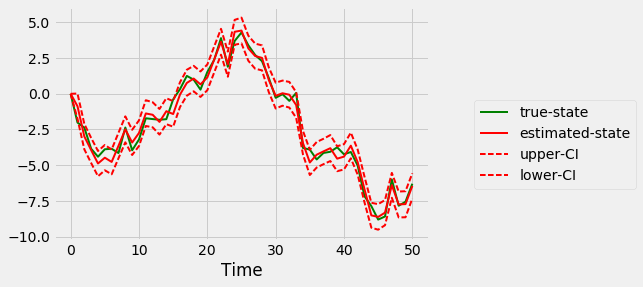

In [3]:
#線形・ガウス型でシステム方程式、観測方程式は以下。
def system_equation_1(x, t):
    v = normal(0,1,1)
    return x + v
def obs_equation_1(x):
    e = normal(0,0.5)
    return x + e
#予測分布の発生式
def system_equation_gen_1(x_samples, t):
    v = normal(0,1,len(x_samples))
    return x_samples + v
#尤度の計算式
def obs_L_1(x,y):
    t = y-x
    return (1/np.sqrt(2*np.pi*0.25))*np.exp(-1 * (t**2) / 0.5)

#10000個の0の値の粒子から、50ステップのシミュレーションを行う。
MCF_1 = MCF(system_equation_1, obs_equation_1, system_equation_gen_1, obs_L_1, np.zeros(10000),50)
#初期値x_0を0として、T=50までの真の状態x_tと観測値y_tを発生させる
MCF_1.DataGenerate(true_x_0 = 0,plot=False)
#計算を行う
MCF_1.Filtering()
summary_control = MCF_1.Get_summary(plot=True)
x_control = MCF_1.sim_x
mse_control = MCF_1.MSE()

100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Simulation finished successfully.


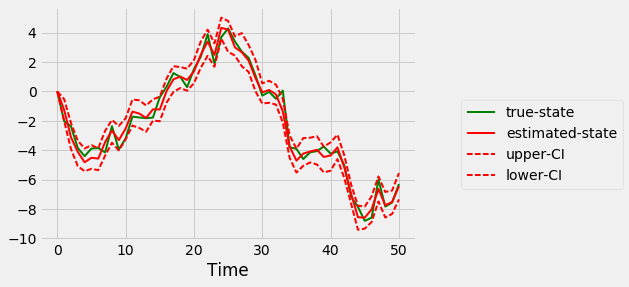

In [9]:
#固定ラグ（10とする）平滑化を加えた計算を行う
MCF_1.Filtering(smoothing_lag=10)
summary_test = MCF_1.Get_summary(plot=True)
x_test = MCF_1.sim_x
mse_test = MCF_1.MSE()

なめらかになっていることが分かる！ ちなみにsmoothingは滑らかな自然な変化を目指すものであり、精度向上を志すものではないので、MSEは向上しない。

###### 多様性の低下も確認する。

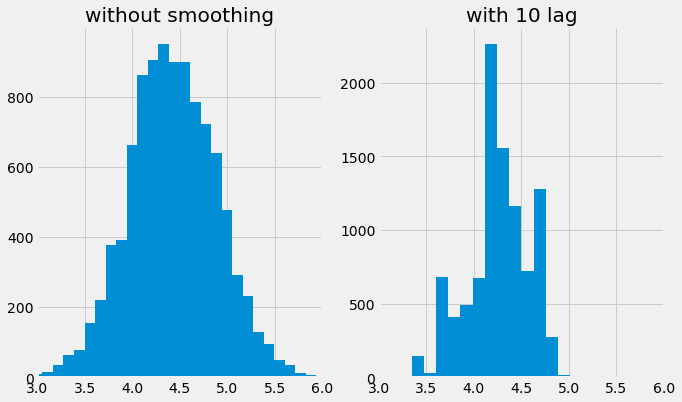

In [11]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.hist(x_control[25], bins=30)
plt.xlim(3,6)
plt.title("without smoothing")
plt.subplot(1,2,2)
plt.hist(x_test[25], bins=20)
plt.title("with 10 lag")
plt.xlim(3,6)
plt.show()

確かに、かなり低下している。

###### SVモデルへの適用

100%|██████████| 200/200 [00:31<00:00,  6.39it/s]


Simulation finished successfully.


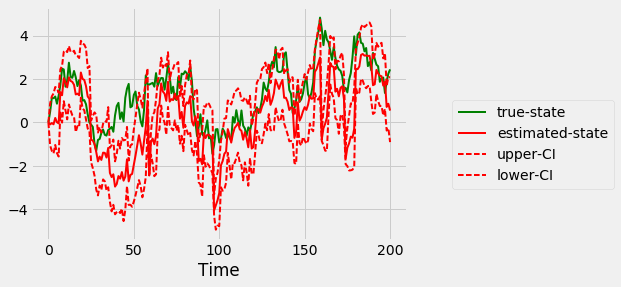

In [22]:
#システム方程式、観測方程式は以下。
def system_equation_3(x, t):
    v = normal(0,0.5)
    return 0.98 * x + v
def obs_equation_3(x):
    e = normal(0,1)
    return e * np.exp(x/2)

#予測分布の発生式
def system_equation_gen_3(x_samples, t):
    v = normal(0,0.5,len(x_samples))
    return 0.98 * x_samples + v

#尤度の計算式
def obs_L_3(x,y):
    s = 0
    if y[0] >0:
        s = np.log(y) - x/2
    else:
        s = -np.log(-y) + x/2
    return np.exp(s - np.exp(2*s) / 2) / np.sqrt(2*np.pi)

#10000個の0の値の粒子から、200ステップのシミュレーションを行う。
MCF_3 = MCF(system_equation_3, obs_equation_3, system_equation_gen_3, obs_L_3, np.zeros(10000),200)
#初期値x_0を0として、T=200までの真の状態x_tと観測値y_tを発生させる
MCF_3.DataGenerate(true_x_0 = 0)
MCF_3.Filtering()
summary_control = MCF_3.Get_summary(Per_CI=0.95,plot=True)
x_control = MCF_3.sim_x
mse_control = MCF_3.MSE()

100%|██████████| 200/200 [00:44<00:00,  4.51it/s]


Simulation finished successfully.


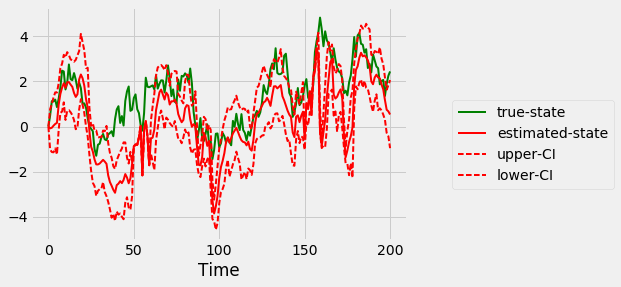

In [23]:
#ラグ増やし過ぎると多様性が本当になくなる。
MCF_3.Filtering(smoothing_lag=10)
summary_test = MCF_3.Get_summary(Per_CI=0.95,plot=True)
x_test = MCF_3.sim_x
mse_test = MCF_3.MSE()

In [29]:
#ちなみに
print("MSE without smoothing is", mse_control)
print("MSE with 10 lag smoothing is", mse_test)

MSE without smoothing is 2.70912215688
MSE with 10 lag smoothing is 2.45026223863


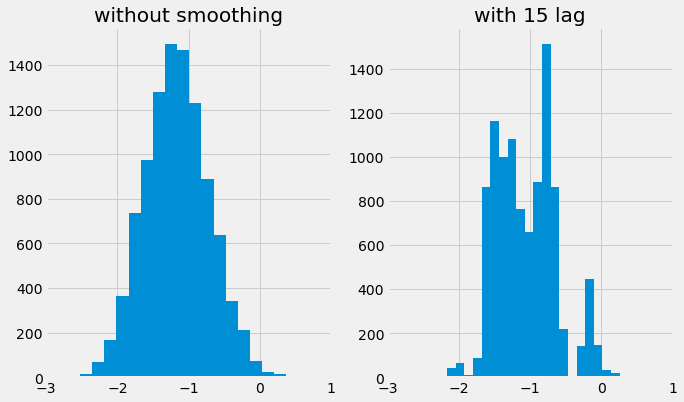

In [28]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.hist(x_control[175], bins=20)
plt.xlim(-3,1)
plt.title("without smoothing")
plt.subplot(1,2,2)
plt.hist(x_test[175], bins=20)
plt.xlim(-3,1)
plt.title("with 15 lag")
plt.show()

確かに多様性の低下は大きな問題と思われる。<br>
また、やっぱり大幅な予測ミスに対応しきれていないように感じる。ベストは、smoothingも組み合わせることで、上手く修正するモデルである。ここでは、しっかりと裾野を広げて多様性を保ちながらシミュレーションすることが恐らく効果的だろう（もしくは、複数ステップ間で尤度計算をするか）。例えば、遠い場所の尤度を上方修正する（下界を定める）orGAみたいに値を敢えて散らす->MCMC? などによって粒子の多様性を増加させた方がいいのかも。あ、まずは補助粒子フィルタの利用が良さそう。<br>
もちろん、exp(exp)の計算部分による問題もまだ残っているかもしれないけれど...